In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import gin
import ddsp
from ddsp import spectral_ops, core
from IPython.display import Audio
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore")

In [2]:
sample_rate = 16000
hop_size = 64
step_dur = hop_size / sample_rate

In [3]:
def specplot(audio,
             vmin=-5,
             vmax=1,
             rotate=True,
             size=512 + 256,
             **matshow_kwargs):
    """Plot the log magnitude spectrogram of audio."""
    # If batched, take first element.
    if len(audio.shape) == 2:
        audio = audio[0]

    logmag = spectral_ops.compute_logmag(core.tf_float32(audio), size=size)
    if rotate:
        logmag = np.rot90(logmag)
    # Plotting.
    plt.figure(figsize=(12,8))
    plt.matshow(logmag,
                vmin=vmin,
                vmax=vmax,
                cmap=plt.cm.magma,
                aspect='auto',
                fignum=1,
                **matshow_kwargs)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Time')
    plt.ylabel('Frequency')

In [4]:
def auto_tune(f0_midi, tuning_factor, mask_on, amount=0.0, chromatic=False):
    """Reduce variance of f0 from the chromatic or scale intervals."""
    if chromatic:
        midi_diff = (f0_midi - tuning_factor) % 1.0
        midi_diff[midi_diff > 0.5] -= 1.0
    else:
        major_scale = np.ravel(
          [np.array([0, 2, 4, 5, 7, 9, 11]) + 12 * i for i in range(10)])
        all_scales = np.stack([major_scale + i for i in range(12)])

        f0_on = f0_midi[mask_on]
        # [time, scale, note]
        f0_diff_tsn = (
          f0_on[:, np.newaxis, np.newaxis] - all_scales[np.newaxis, :, :])
        # [time, scale]
        f0_diff_ts = np.min(np.abs(f0_diff_tsn), axis=-1)
        # [scale]
        f0_diff_s = np.mean(f0_diff_ts, axis=0)
        scale_idx = np.argmin(f0_diff_s)
        scale = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb',
               'G', 'Ab', 'A', 'Bb', 'B', 'C'][scale_idx]

        # [time]
        f0_diff_tn = f0_midi[:, np.newaxis] - all_scales[scale_idx][np.newaxis, :]
        note_idx = np.argmin(np.abs(f0_diff_tn), axis=-1)
        midi_diff = np.take_along_axis(
          f0_diff_tn, note_idx[:, np.newaxis], axis=-1)[:, 0]
        print('Autotuning... \nInferred key: {}  '
            '\nTuning offset: {} cents'.format(scale, int(tuning_factor * 100)))

    # Adjust the midi signal.
    return f0_midi - amount * midi_diff

In [16]:
model = pretrained.value

# Pretrained models.
PRETRAINED_DIR = f'pretrained/{model.lower()}'

model_dir = PRETRAINED_DIR
gin_file = os.path.join(model_dir, 'operative_config-0.gin')

# Parse gin config,
with gin.unlock_config():
    gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in os.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = len(af['f0_hz'])
n_samples = time_steps * hop_size

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
    gin.parse_config(gin_params)


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)

# Build model by running a batch through it.
_ = model(af, training=False)

InternalError: Failed to call ThenRnnForward with model config: [rnn_mode, rnn_input_mode, rnn_direction_mode]: 3, 0, 0 , [num_layers, input_size, num_units, dir_count, max_seq_length, batch_size, cell_num_units]: [1, 1024, 512, 1, 3000, 1, 0]  [Op:CudnnRNN]

In [6]:
pretrained = widgets.Dropdown(
    options=['Violin', 'Flute', 'Flute2', 'Cello', 'Viola'],
    value='Cello',
    description='Pretrained:',
    disabled=False,
)
display(pretrained)

Dropdown(description='Pretrained:', index=3, options=('Violin', 'Flute', 'Flute2', 'Cello', 'Viola'), value='C…

In [8]:
def oscillate(t, freq, center, range, phase=0., power=1):
    return center + range * np.sin(freq * 2 * np.pi * (t + phase)) ** power

In [9]:
def perc(attack_ratio=0.1, duration=0.5, peak=1.0):
    num_steps = int(duration / step_dur)
    attack_steps = int(num_steps * attack_ratio)
    decay_steps = num_steps - attack_steps
    
    result = np.zeros(num_steps)
    attack = np.linspace(0., peak, attack_steps)
    decay = np.linspace(peak, 0., decay_steps)
    
    result[:attack_steps] = attack
    result[-decay_steps:] = decay
    
    return result

In [14]:
def adsr(a, d, s, r, dur, peak, vol):
    factor = dur / sum([a, d, s, r])
    num_steps = int(dur / step_dur)
    
    attack_steps = int(num_steps * a / factor)
    decay_steps = int(num_steps * d / factor)
    sustain_steps = int(num_steps * s / factor)
    release_steps = num_steps - (attack_steps + decay_steps + sustain_steps)
    
    attack = np.linspace(0., peak, attack_steps)
    decay = np.linspace(peak, vol, decay_steps)
    sustain = np.linspace(vol, vol, sustain_steps)
    release = np.linspace(vol, 0., release_steps)
    
    return np.concatenate([attack, decay, sustain, release])

In [11]:
def silence(duration=0.5):
    return np.zeros(int(duration / step_dur))

In [12]:
def rescale(xs, min_val, max_val):
    return xs * (max_val - min_val) + min_val

12.0


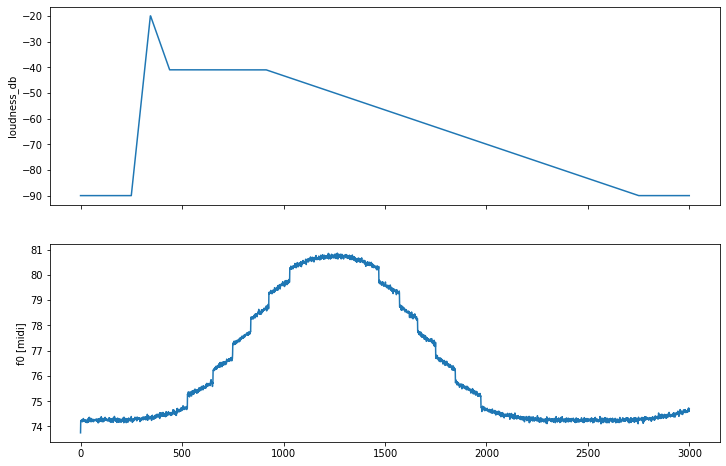

In [15]:
loudness = adsr(0.2, 0.2, 1., 0.5, 10., 1., 0.7)
preroll = silence(1.)
postroll = silence(1.)
loudness = np.concatenate([preroll, loudness, postroll])
loudness = rescale(loudness, -90, -20)
    

n_steps = len(loudness)
duration = n_steps * step_dur
print(duration)

t = np.linspace(0, duration, n_steps)

pitch = oscillate(t, 0.05, 74, 7, 0, 4)
pitch = auto_tune(pitch, 0.5, np.ones_like(pitch, dtype='bool')*0.5, amount=.5, chromatic=True)
pitch += np.random.randn(n_steps) * 0.05

af = {
    'f0_hz': librosa.midi_to_hz(pitch),
    'loudness_db': loudness
}

# Plot
fig, ax = plt.subplots(nrows=2, 
                       ncols=1, 
                       sharex=True,
                       figsize=(12, 8))

ax[0].plot(af['loudness_db'])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(af['f0_hz']))
ax[1].set_ylabel('f0 [midi]')
pass

Resynthesis


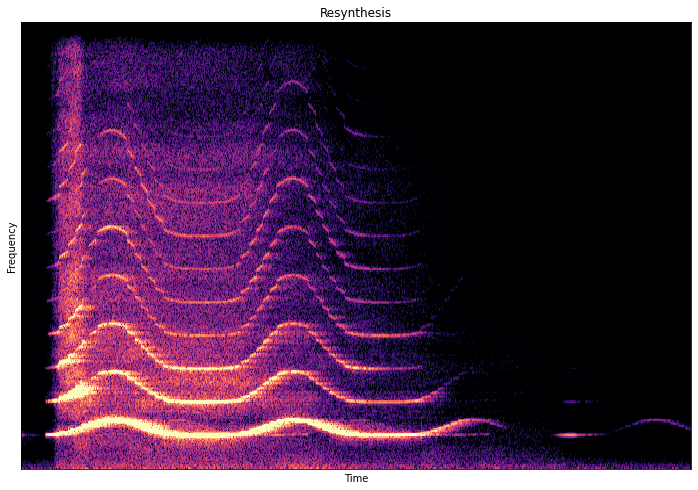

In [79]:
# Run a batch of predictions.
outputs = model(af, training=False)
audio_gen = model.get_audio_from_outputs(outputs)

print('Resynthesis')
play = Audio(audio_gen, rate=16000)
display(play)
specplot(audio_gen)
_ = plt.title("Resynthesis")